# Section 4.2: Cardinality Distortion - Impact of Cost Model and Plan Search Space

In [1]:
import sys
sys.path.append("../postbound/postbound")

In [2]:
from collections.abc import Iterable

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from postbound.experiments import workloads

import analysis

In [3]:
results_base = "../datasets/01-cardinality-distortion"
workloads.workloads_base_dir = "../postbound/workloads"
plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
sns.set_style("whitegrid")
sns.set_context("talk")

## General definitions

In [4]:
job = workloads.job()

In [5]:
stages = {
    1: "minimal",
    2: "textbook",
    3: "textbook-opt",
    4: "intermediates",
    5: "parallel"
}

e2e_df = pd.read_csv(f"{results_base}/end-to-end-job.csv", converters={"query_plan": analysis.load_pg_explain})
e2e_df["label"] = pd.Categorical(e2e_df["label"], categories=job.labels(), ordered=True)
e2e_df["stage"] = e2e_df["enumerator_stage"].map(stages)
e2e_df["stage"] = pd.Categorical(e2e_df["stage"], categories=stages.values(), ordered=True)
e2e_df["plan_hash"] = e2e_df["query_plan"].map(hash)

In [6]:
def count_plan_changes(plans: pd.Series) -> int:
    change_indicators = plans != plans.shift(-1)
    return change_indicators.sum() - 1


def count_jump_backs(plans: pd.Series) -> int:
    jumps = 0
    prev_plan = plans.iloc[0]
    seen_plans = {prev_plan}
    for plan in plans.iloc[1:]:
        if plan == prev_plan:
            continue

        if plan in seen_plans:
            jumps += 1
        seen_plans.add(plan)
        prev_plan = plan
    return jumps

In [7]:
changes_df = (e2e_df
              .groupby(["cost_model", "label", "stage"], as_index=False, observed=True)
              .agg(plan_changes=pd.NamedAgg(column="plan_hash", aggfunc=count_plan_changes),
                   jump_backs=pd.NamedAgg(column="plan_hash", aggfunc=count_jump_backs))
              .sort_values(["cost_model", "label", "stage"])
)
changes_df["plot_label"] = changes_df.apply(lambda row: f"{row['plan_changes']} ({row['jump_backs']})", axis=1)
changes_df

,cost_model,label,stage,plan_changes,jump_backs,plot_label
0,cout,1a,minimal,2,1,2 (1)
1,cout,1a,textbook,4,1,4 (1)
2,cout,1a,textbook-opt,4,1,4 (1)
3,cout,1a,intermediates,4,1,4 (1)
4,cout,1a,parallel,5,1,5 (1)
...,...,...,...,...,...,...
1125,postgres,33c,minimal,15,1,15 (1)
1126,postgres,33c,textbook,18,2,18 (2)
1127,postgres,33c,textbook-opt,18,2,18 (2)
1128,postgres,33c,intermediates,19,2,19 (2)


## Figure 5: Number of plan changes across all distortion factors for select queries.

In [8]:
vmin, vmax = 0, changes_df["plan_changes"].max()
cmap = sns.color_palette("Blues", 12, as_cmap=True)

stages_pretty = {
        "minimal": "SeqScan\nNestLoopJ\n(minimal)",
        "textbook": "+\nIdxScan\nMergeJ.\nHashJ.",
        "textbook-opt": "+\nIdxOnlyS.\nBitmapS.",
        "intermediates": "+\nMemoize\nMaterial",
        "parallel": "+\nParallel.\n(full)"
    }

changes_df["stage_pretty"] = pd.Categorical(changes_df["stage"].map(stages_pretty), categories=stages_pretty.values(), ordered=True)

def plot_enumerator_evolution(df: pd.DataFrame, queries: Iterable[str]) -> tuple[mpl.figure.Figure, mpl.axes.Axes]:
    data_matrix = df.pivot(index="label", columns="stage_pretty", values="plan_changes").loc[queries]
    annot_matrix = df.pivot(index="label", columns="stage_pretty", values="plot_label").loc[queries]

    fig, ax = plt.subplots()
    g = sns.heatmap(data_matrix, annot=annot_matrix,
                    fmt="", cmap=cmap,
                    vmin=vmin, vmax=vmax,
                    linewidth=1, cbar=False,
                    annot_kws={"size": 18, "fontweight": "normal"},
                    ax=ax)
    g.set(xlabel="Available physical operators", ylabel="Query")
    g.tick_params(axis="both", which="major", labelsize=16)

    for i in range(len(df)):
        ax.axhline(i, color="white", lw=7.5)
    fig.tight_layout()

    return fig, ax

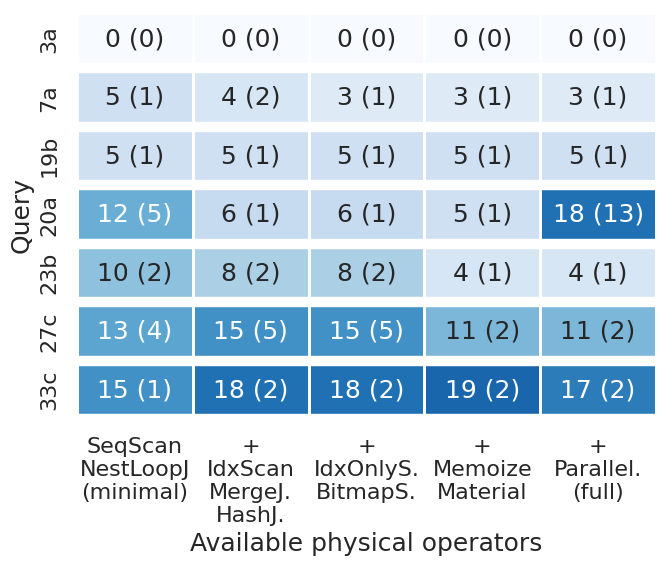

In [9]:
queries = ["3a", "7a", "19b", "20a", "23b", "27c", "33c"]
fig_vanilla, ax_vanilla = plot_enumerator_evolution(changes_df.query("cost_model == 'postgres'"), queries)
fig_vanilla.savefig("plots/distortion-end-to-end-vanilla.pdf")

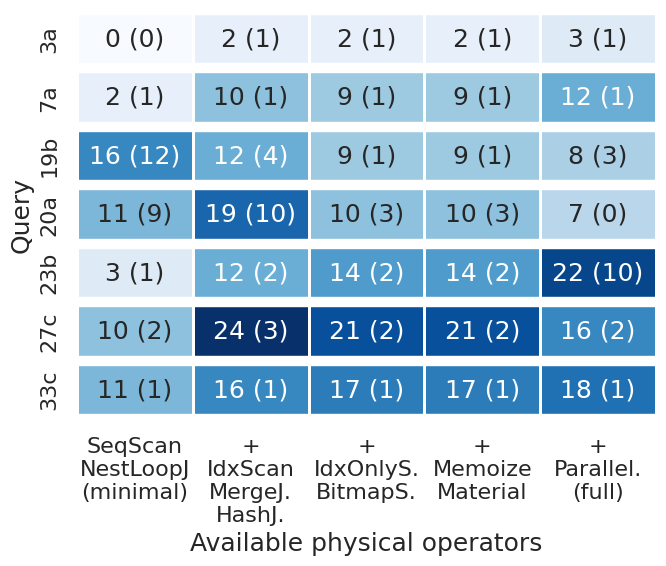

In [10]:
fig_cout, ax_cout = plot_enumerator_evolution(changes_df.query("cost_model == 'cout'"), queries)
fig_cout.savefig("plots/distortion-end-to-end-cout.pdf")

## Numbers used throughout the text

In [11]:
extremes_df = (changes_df
               .drop(columns=["plot_label", "stage_pretty"])
               .query("stage == 'minimal' | stage == 'parallel'")
               .pivot(columns=["stage"], index=["cost_model", "label"]))
extremes_df.columns = [f"{measure}_{stage[:3]}" for measure, stage in extremes_df.columns.to_flat_index()]
extremes_df.reset_index(inplace=True)
extremes_df

,cost_model,label,plan_changes_min,plan_changes_par,jump_backs_min,jump_backs_par
0,cout,1a,2,5,1,1
1,cout,1b,2,6,1,1
2,cout,1c,0,5,0,1
3,cout,1d,3,6,1,1
4,cout,2a,0,1,0,0
...,...,...,...,...,...,...
221,postgres,32a,1,5,0,1
222,postgres,32b,4,4,1,1
223,postgres,33a,7,10,1,2
224,postgres,33b,11,11,1,0


**Number of queries where the minimal setting produces _less_ plans than the full setting:**

In [12]:
(extremes_df
 .query("plan_changes_min < plan_changes_par")
 .groupby("cost_model", as_index=False)
 ["label"]
 .count())

,cost_model,label
0,cout,103
1,postgres,72


**Number of queries where the minimal setting produces _more_ plans than the full setting:**

In [13]:
(extremes_df
 .query("plan_changes_min > plan_changes_par")
 .groupby("cost_model", as_index=False)
 ["label"]
 .count())

,cost_model,label
0,cout,6
1,postgres,26


**Number of queries where an intermediate stage has the most plan changes:**

In [14]:
(changes_df
 .merge(
     changes_df.query("stage == 'minimal'")[["cost_model", "label", "plan_changes"]],
     on=["cost_model", "label"], suffixes=("", "_min"))
 .merge(
     changes_df.query("stage == 'parallel'")[["cost_model", "label", "plan_changes"]],
     on=["cost_model", "label"], suffixes=("", "_full"))
 .query("stage != 'minimal' & stage != 'parallel' & plan_changes > plan_changes_min & plan_changes > plan_changes_full")
 .groupby(["cost_model", "label"], as_index=False, observed=True)
 ["plan_changes"]
 .agg(lambda xs: 1)
 .groupby("cost_model", as_index=False, observed=True)
 ["label"]
 .count()
)

,cost_model,label
0,cout,30
1,postgres,30


**Number of queries where the minimal setting produces more jumps than the full setting:**

In [15]:
(extremes_df
 .query("jump_backs_min > jump_backs_par")
 .groupby("cost_model", as_index=False)["label"]
 .count())

,cost_model,label
0,cout,16
1,postgres,20


**Number of queries where the minimal setting produces less jumps than the full setting:**

In [16]:
extremes_df.query("jump_backs_min < jump_backs_par").groupby("cost_model", as_index=False)["label"].count()

,cost_model,label
0,cout,73
1,postgres,62


**Number of queries where an intermediate stage has the most jumps:**

In [17]:
(changes_df
 .merge(
     changes_df.query("stage == 'minimal'")[["cost_model", "label", "jump_backs"]],
     on=["cost_model", "label"], suffixes=("", "_min"))
 .merge(
     changes_df.query("stage == 'parallel'")[["cost_model", "label", "jump_backs"]],
     on=["cost_model", "label"], suffixes=("", "_full"))
 .query("stage != 'minimal' & stage != 'parallel' & jump_backs > jump_backs_min & jump_backs > jump_backs_full")
 .groupby(["cost_model", "label"], as_index=False, observed=True)
 ["jump_backs"]
 .agg(lambda xs: 1)
 .groupby("cost_model", as_index=False, observed=True)
 ["label"]
 .count()
)

,cost_model,label
0,cout,11
1,postgres,12
